# Part 1 - Hypothesis

#### Importing necessary libraries

In [48]:
import numpy as np
import pandas as pd
import math
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

#### Loading the dataset and isolating the requisite column

In [49]:
df = pd.read_csv("data.csv")
data = df["A-E"]
print(type(data))

<class 'pandas.core.series.Series'>


#### Plotting the data in the form of a histogram with 20 bins

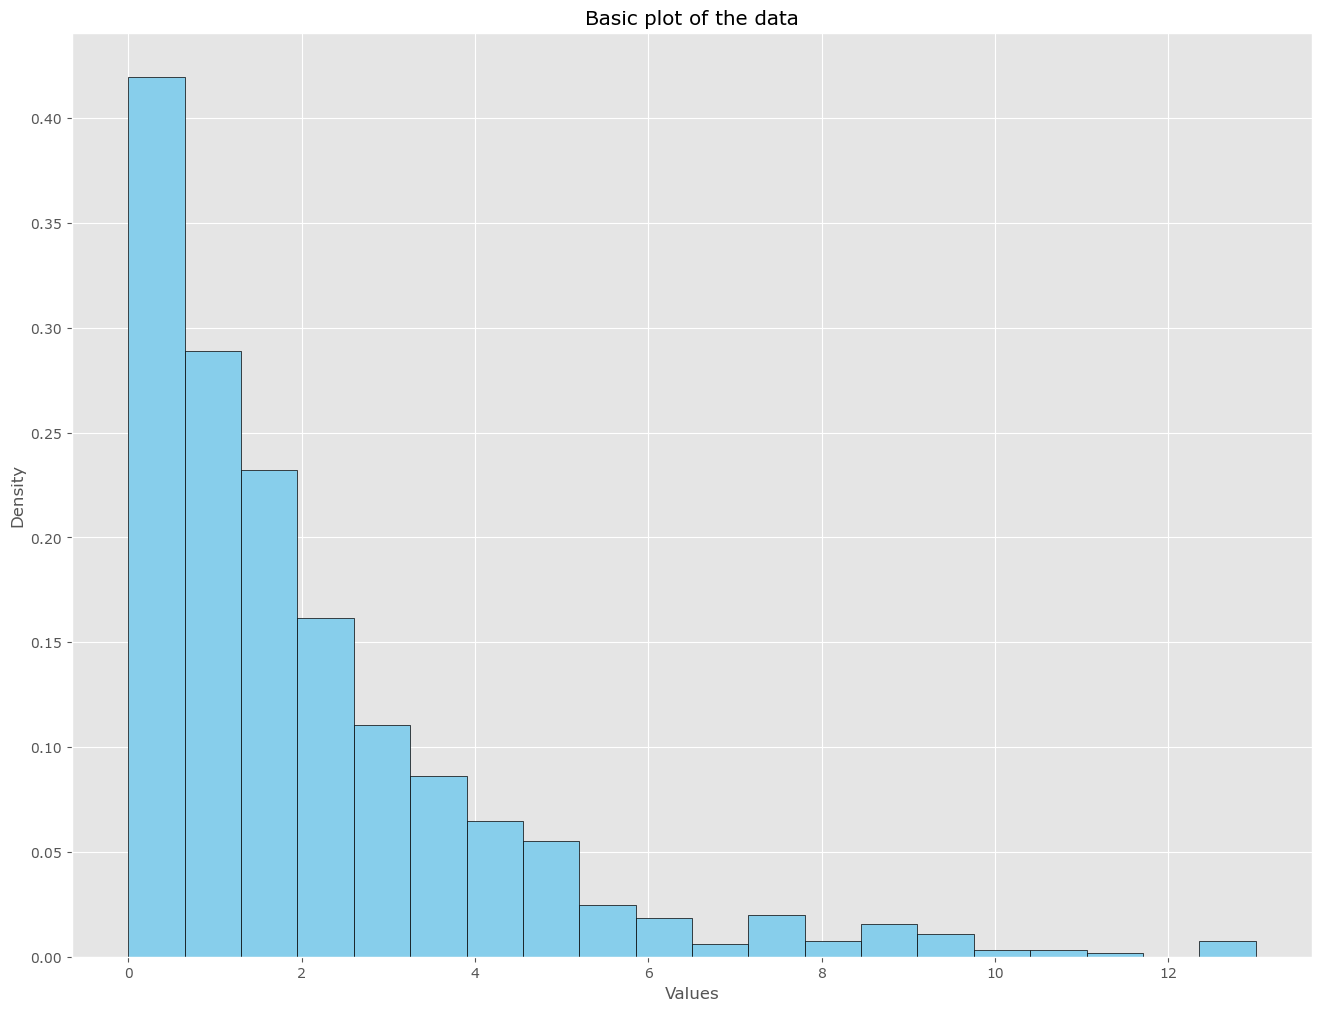

In [50]:
plt.hist(data, bins=20, color='skyblue', edgecolor='black', density=True)
 
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Basic plot of the data')
 
# Display the plot
plt.show()

#### Computing critical statistics of the dataset and compiling them in a table

In [51]:
def desc_df(df):
    # Calculation of statistics of the dataset
    basic_stats = {}
    basic_stats["Minimum"] = data.min()
    basic_stats["Maximum"] = data.max()
    basic_stats["Average"] = data.mean().round(2)
    basic_stats["Standard Deviation"] = data.std().round(2)
    basic_stats["Median"] = data.median().round(2)
    basic_stats["First Quartile"] = data.quantile(0.25).round(2)
    basic_stats["Third Quartile"] = data.quantile(0.75).round(2)
    basic_stats["Interquartile range"] = basic_stats["Third Quartile"] - basic_stats["First Quartile"]
    basic_stats["Skewness"] = data.skew().round(2)

    # Calculation of mode of continuous data using bins
    bin_size = 28
    bins = list(np.linspace(0,13.5,bin_size))
    max_bin = 0
    count = 0
    while count < bin_size-1:
        if len(data[data.between(bins[count],bins[count+1])]) > max_bin:
            max_bin = len(data[data.between(bins[count],bins[count+1])])
            a = count
        else:
            pass
        count += 1
    
    basic_stats['Mode'] = 'Bin (' + str(bins[a]) + ',' + str(bins[a+1]) + ')'
    basic_stats_table = pd.DataFrame(basic_stats, index = [0])
    return basic_stats_table
 

table = desc_df(data)
table

,Minimum,Maximum,Average,Standard Deviation,Median,First Quartile,Third Quartile,Interquartile range,Skewness,Mode
0,0.001504,13.00807,2.11,2.14,1.44,0.61,2.95,2.34,1.95,"Bin (0.0,0.5)"


#### Since the Average of the dataset and the Standard deviation of the dataset are approximately equal, the distribution of the dataset could be a Gamma distribution with Alpha = 1

# Part 2 - Fit distribution

#### Creating a function that identifies the best distribution that fits the given dataset from a set of distributions

In [52]:
def fit_dist(data, bins=200, ax=None):
    # Generating a histogram of the original data and finding midpoints of the bins
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Creating a list to hold the distribution names
    best_distributions = []
    distribution_dict = {'Normal distribution':st.norm, 'Gamma distribution':st.gamma,'Beta distribution':st.beta}

    # Estimating the distribution parameters from data
    for key in distribution_dict:
        print("{}".format(key))
        distribution = distribution_dict[key]
                
        # Fitting distribution to data
        params = distribution.fit(data)

        # Isolating the individual parameters
        args = params[:-2] # Refers to the shape parameter(s)
        loc = params[-2] # Refers to the location parameter
        scale = params[-1] # Refers to the size parameter
                
        # Calculating the fitted PDF and sum of squared error (SSE) in comparison to the distribution
        pdf = distribution.pdf(x, loc=loc, scale=scale, *args)
        sse = np.sum(np.power(y - pdf, 2.0))
                
        pd.Series(pdf, x).plot(ax=ax, label=key, legend=True)

        # Identifying if this distribution is better
        best_distributions.append((distribution, params, sse))

    # Returning the list of distributions in the order of least SSE
    return sorted(best_distributions, key=lambda a:a[2])

#### Creating a function that generates a distribution's Probability Distribution Function (PDF)

In [53]:
def generate_pdf(dist, params, size=10000):

    # Separating the parts of parameters
    args = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Getting the same start and end points of distribution
    start = dist.ppf(0.01, *args, loc=loc, scale=scale) if args else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *args, loc=loc, scale=scale) if args else dist.ppf(0.99, loc=loc, scale=scale)

    # Building the PDF and turning it into a pandas series object
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *args)
    pdf = pd.Series(y, x)

    return pdf

#### Plotting graphs for the given dataset and distributions

Normal distribution
Gamma distribution
Beta distribution


/private/var/containers/Bundle/Application/9F03D818-3432-4E60-ADF0-45D7CF19816B/Carnets-sci.app/Library/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/private/var/containers/Bundle/Application/9F03D818-3432-4E60-ADF0-45D7CF19816B/Carnets-sci.app/Library/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0, 0.5, 'Frequency')

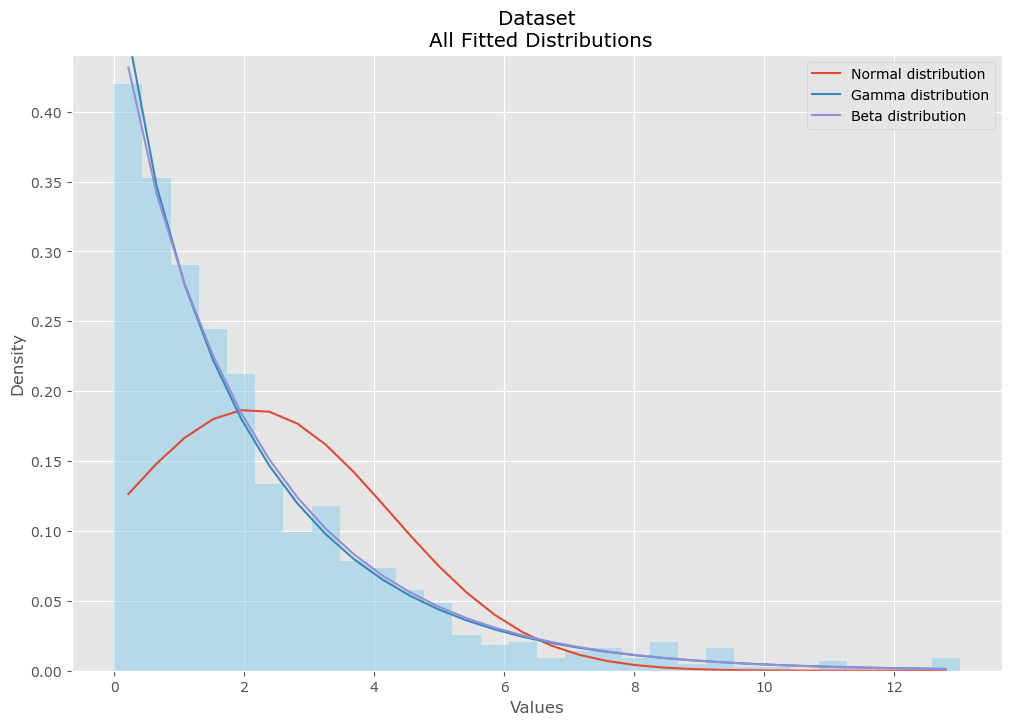

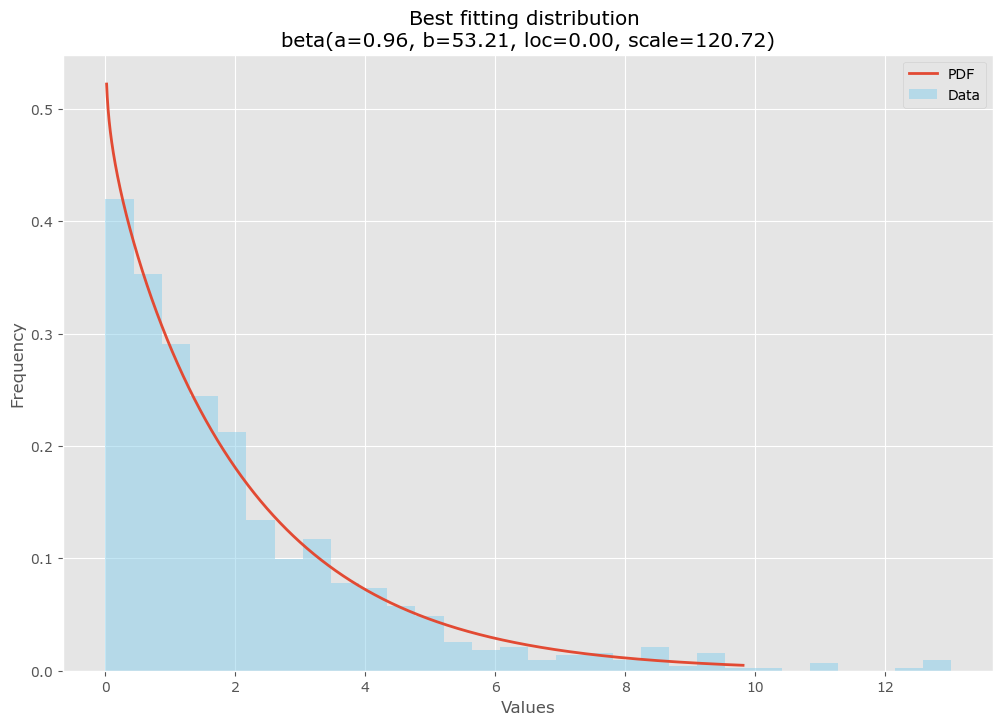

In [54]:
# Determining the number of bins using Sturges' rule
bin_size = 30 #int(1+3.322*math.log10(data.count()))

# Plotting the given data for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=bin_size, density=True, alpha=0.5, color='skyblue')

# Saving plot limits for future plots
yLim = ax.get_ylim()

# Finding the best fitting distribution
dists = fit_dist(data, bin_size, ax)
best_dist = dists[0]

# Updating plots
ax.set_ylim(yLim)
ax.set_title(u'Dataset\n All Fitted Distributions')
ax.set_xlabel(u'Values')
ax.set_ylabel('Density')

# Generating the PDF with the best parameters 
pdf = generate_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=bin_size, density=True, alpha=0.5, label='Data', legend=True, ax=ax, color='skyblue')

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'Best fitting distribution \n' + dist_str)
ax.set_xlabel(u'Values')
ax.set_ylabel('Frequency')